In [84]:
from source import source
import yfinance as yf
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error as mse
from Backtesting.SingleTickerBacktesting import SimplePortfolioExperiment
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Gathering data

In [85]:
yndx = yf.Ticker("yndx")
model_prices = yndx.history(start="2011-05-24", end="2016-12-31", interval='1d').Close
experiment_prices = yndx.history(start="2016-12-31", end="2017-12-31", interval='1d').Close
experiment_prices

Date
2017-01-03 00:00:00-05:00    20.430000
2017-01-04 00:00:00-05:00    20.440001
2017-01-05 00:00:00-05:00    21.879999
2017-01-06 00:00:00-05:00    21.840000
2017-01-09 00:00:00-05:00    21.950001
                               ...    
2017-12-22 00:00:00-05:00    31.660000
2017-12-26 00:00:00-05:00    32.200001
2017-12-27 00:00:00-05:00    32.450001
2017-12-28 00:00:00-05:00    32.560001
2017-12-29 00:00:00-05:00    32.750000
Name: Close, Length: 251, dtype: float64

Let us first try the most simple strategy to sell if the price is going down the next day / buy if it is going to go up.

In [86]:
class Config:
    INPUT_WINDOW_SIZE = 60
    OUTPUT_WINDOW_SIZE = 5

X, y = source.prepare_data(model_prices.values,
                           input_window_size=Config.INPUT_WINDOW_SIZE,
                           output_window_size=Config.OUTPUT_WINDOW_SIZE
                           )
X.shape, y.shape

D:\MLDS\Year_1_project\source\source.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x)


((270, 60), (270, 1))

In [87]:
y = y.ravel()

In [88]:
model = GradientBoostingRegressor()

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [90]:
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [91]:
predictions = model.predict(X_test)

In [92]:
mse(y_test, predictions)

0.0062195821968292035

Seems good enough for me.

In [93]:
model.fit(X, y)

GradientBoostingRegressor()

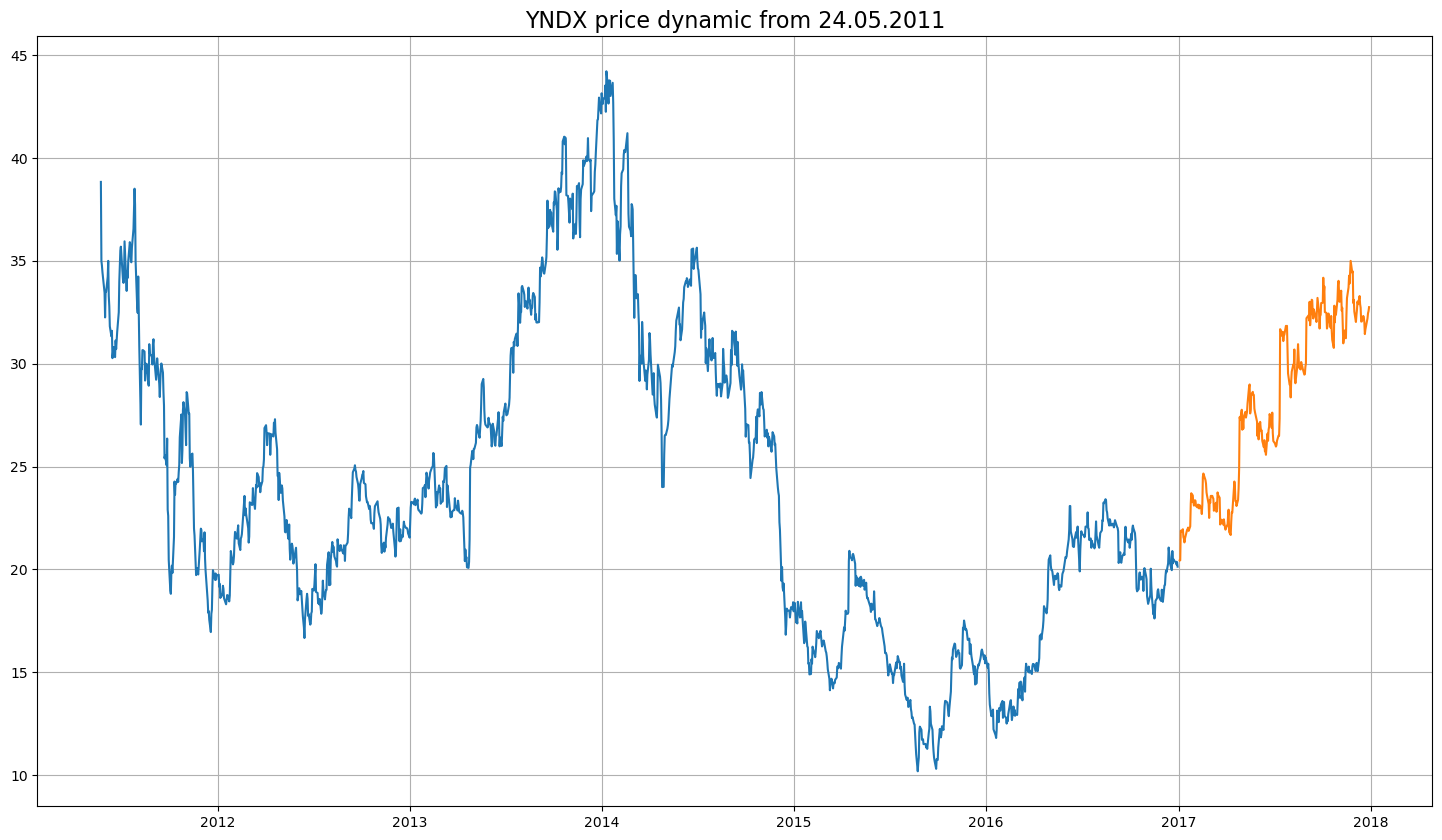

In [94]:
data = yf.Ticker('YNDX').history(period="max")
plt.figure(figsize = (18, 10))
plt.title('YNDX price dynamic from 24.05.2011', font = 'Times', fontsize = 16)
plt.grid()
plt.plot(model_prices)
plt.plot(experiment_prices)
plt.show()

In [95]:
class BaselineBacktest(SimplePortfolioExperiment):
    def make_action(self, ind):
        self.buy_stocks_per_money(self.free_money, ind, True)

In [96]:
baseline_experiment = BaselineBacktest(window_size=Config.INPUT_WINDOW_SIZE,
                                       days_per_action=5,
                                       historical_data=experiment_prices)
baseline_experiment.start_experiment()

Start portfolio experiment.


100%|██████████| 250/250 [00:00<00:00, 250137.40it/s]


In [97]:
LOG_purch = 0
LOG_sold = 0

In [108]:
THRESHOLD = 0

class Backtest(SimplePortfolioExperiment):
    def make_action(self, ind):
        global LOG_sold
        global LOG_purch
        prediction_data = \
            self.historical_data[ind - self.window_size + 1:ind + 1]
        transformed_data = source._transform_to_DOIU(prediction_data)
        current_price = transformed_data[-1]
        prediction = model.predict(transformed_data.reshape(1, -1))

        if current_price - prediction > THRESHOLD:
            self.buy_partial(0.5, ind=ind, partial_operation=True)
            LOG_sold += 1
        elif current_price - prediction < THRESHOLD:
            self.sell_partial_papers(0.5, ind=ind, partial_operation=True)
            LOG_purch += 1

In [109]:
experiment = Backtest(window_size=Config.INPUT_WINDOW_SIZE,
                      days_per_action=5,
                      historical_data=experiment_prices)
experiment.start_experiment()

Start portfolio experiment.


  0%|          | 0/250 [00:00<?, ?it/s]D:\MLDS\Year_1_project\source\source.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x)
D:\MLDS\Year_1_project\source\source.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x)
D:\MLDS\Year_1_project\source\source.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating th

In [100]:
LOG_sold, LOG_purch

(26, 13)

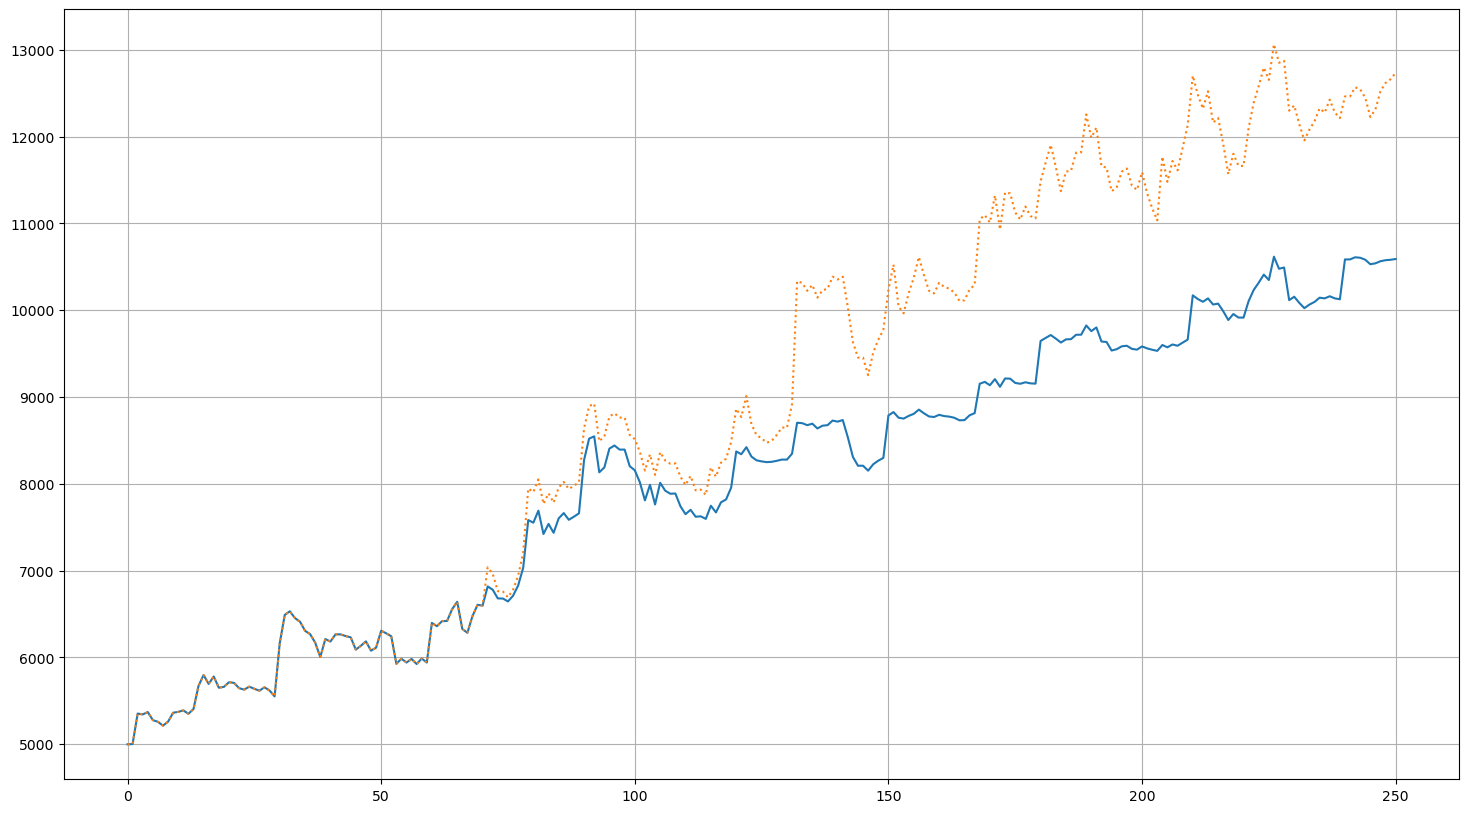

In [110]:
plt.figure(figsize = (18, 10))
plt.plot(experiment.history_capital)
plt.plot(baseline_experiment.history_capital, ls=':')
plt.grid()
plt.show()